In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Plotting path

In [2]:
### x = [x, y, r, theta]
def f(x): return np.array([x[2]*x[1]**2,
                          -2/x[2]*x[0]*x[1],
                          x[0],
                          x[1]])

In [3]:
def var_search (x0a,r1,r2):
    
    x0b = np.zeros(4)
    
    x0b[0] = x0a[0]
    x0b[1] = x0a[1]
    x0b[2] = np.linalg.norm(r1, ord=2)
    if r1[0] < 0:
        x0b[3] = np.arctan(r1[1]/r1[0])-np.pi
    else :
        x0b[3] = np.arctan(r1[1]/r1[0])

    # x0b[3] = 0.5*(np.arccos(r1[0])+np.arcsin(r1[1]))

    t = np.linspace(0,x0a[2],2001)

    N = t.size
    x = np.zeros((4,N))
    
    x[:,0] = x0b
    
    k = np.zeros((4,4))
    h = t[1]-t[0]

    for i in range(1, t.size):
        
        k[:,0] = f(x[:,i-1])
        
        k[:,1] = f(x[:,i-1] + h/2*k[:,0])
    
        k[:,2] = f(x[:,i-1] + h/2*k[:,1])
    
        k[:,3] = f(x[:,i-1] + h*k[:,2])
    
        x[:,i] = x[:,i-1] + h/6*(k[:,0]+2*k[:,1]+2*k[:,2]+k[:,3])

    u = x[2,-1]*np.cos(x[3,-1])
    v = x[2,-1]*np.sin(x[3,-1])
    rf = np.array([u,v])

    return np.linalg.norm(r2-rf, ord=2)

Input points below.

In [4]:
r1 = np.array([-1,1])
r2 = np.array([8,4])

x0 = np.zeros(3)

x0[0] = 0
x0[1] = 0
x0[2] = 1

                                    ### Note that if your trajectory does not reach, you may need to extend the bound on t
rez = sp.optimize.minimize(var_search, x0, args=(r1,r2), method='Nelder-Mead', bounds=[(-np.linalg.norm(r1-r2),np.linalg.norm(r1-r2)),(-np.pi,np.pi),(0,10)])


In [5]:
def RK4 (f, x0, t):
    
    N = t.size
    x = np.zeros((x0.size,N))
    
    x[:,0] = x0[:]
    
    k = np.zeros((x0.size,4))
    h = t[1]-t[0]

    for i in range(1, t.size):
        
        k[:,0] = f(x[:,i-1])
        
        k[:,1] = f(x[:,i-1] + h/2*k[:,0])
    
        k[:,2] = f(x[:,i-1] + h/2*k[:,1])
    
        k[:,3] = f(x[:,i-1] + h*k[:,2])
    
        x[:,i] = x[:,i-1] + h/6*(k[:,0]+2*k[:,1]+2*k[:,2]+k[:,3])

    return x

In [6]:
if r1[0] < 0:
    theta0 = np.arctan(r1[1]/r1[0])-np.pi
else :
    theta0 = np.arctan(r1[1]/r1[0])
# theta0 = 0.5*(np.arccos(r1[0])+np.arcsin(r1[1]))
x0c = np.array([rez.x[0], rez.x[1], np.linalg.norm(r1, ord=2), theta0])
t = np.linspace(0,rez.x[2],1001)
x = RK4(f,x0c,t)

In [7]:
u = x[2]*np.cos(x[3])
v = x[2]*np.sin(x[3])

In [8]:
print('Distant point:          [{0:0.3f}, {1:0.3f}]'.format(*r2))
print('Final calculated point: [{0:0.3f}, {1:0.3f}]'.format(u[-1],v[-1]))


Distant point:          [8.000, 4.000]
Final calculated point: [8.000, 4.000]


Text(0.5, 1.0, 'Geodesic in Polar')

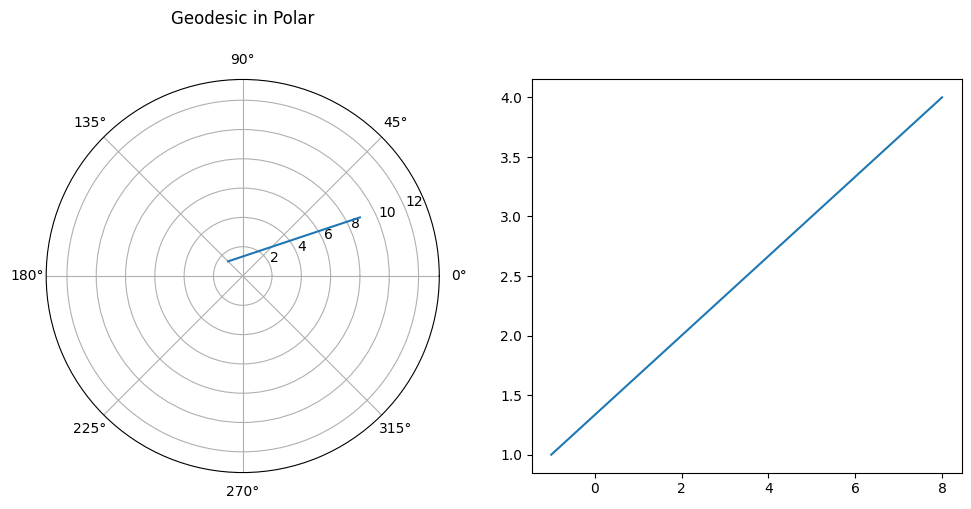

In [9]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1,projection='polar')
ax1.plot(x[3], x[2])
ax1.set_rmax(1.5*max(x[2]))
ax1.set_title("Geodesic in Polar", pad=40)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(u,v)

plt.tight_layout()
plt.show()

# Parallel transport

In [10]:
### x = [dr, dtheta, r, theta], t = s

def g(y,x): ### y = [A0, A1]
    return np.array([x[2]*y[1]*x[1],
                     -(y[0]*x[1]+y[1]*x[0])/x[2]])

A0 = np.array([1,0])
A0 = A0/np.linalg.norm(A0,ord=2)

N = t.size
y = np.zeros((A0.size,N))

y[:,0] = A0[:]

k = np.zeros((A0.size,4))
h = t[1]-t[0]

for i in range(1, t.size):
    
    k[:,0] = g(y[:,i-1], x[:,i-1]) ### using simple forward Euler results in about 1% error for about t=1, n=1000
                                   ### The RK approach 
    k[:,1] = g(y[:,i-1] + h/2*k[:,0], (x[:,i]+x[:,i-1])/2)

    k[:,2] = g(y[:,i-1] + h/2*k[:,1], (x[:,i]+x[:,i-1])/2)

    k[:,3] = g(y[:,i-1] + h*k[:,2], x[:,i])

    y[:,i] = y[:,i-1] + h/6*(k[:,0]+2*k[:,1]+2*k[:,2]+k[:,3])

In [11]:
def arctan_angle(x,r1):
    theta = np.zeros(x.shape[1])
    for i in range(x.shape[1]):    
        if x[0,i] < 0:
            theta[i] = np.arctan(x[1,i]/x[0,i]*r1[i])-np.pi
        else :
            theta[i] = np.arctan(x[1,i]/x[0,i]*r1[i])
    return theta

In [12]:
### This is my own formulation for the transformation from polar basis vectors to Euclidean coordinates.
### I accidentally did this work instead of looking up the proper basis vectors.
### A tactic, I must admit here, that did *not* work for S2.
x[2][::100]
x[3][::100]
y[:,::100]
Y = np.array([np.sqrt(y[0][::100]**2+(y[1][::100]*x[2][::100])**2)*np.cos(x[3][::100]+arctan_angle(y[:,::100],x[2][::100])),
             np.sqrt(y[0][::100]**2+(y[1][::100]*x[2][::100])**2)*np.sin(x[3][::100]+arctan_angle(y[:,::100],x[2][::100]))])
Y
arctan_angle(y[:,::100],x[2][::100])

array([1.41421356, 1.30385941, 1.78889444, 2.54956505, 3.40594557,
       4.3012432 , 5.2154545 , 6.14013703, 7.0711841 , 8.00637565,
       8.94441178])

array([-3.92699082, -4.63562276, -5.17603279, -5.44227858, -5.58091544,
       -5.66292144, -5.71644088, -5.75392281, -5.78156519, -5.80276319,
       -5.81952122])

array([[ 1.        ,  0.75925622,  0.31623644,  0.05548405, -0.08302916,
        -0.16438161, -0.21691256, -0.25334121, -0.27998165, -0.30026743,
        -0.31620927],
       [ 0.        ,  0.49912523,  0.53031597,  0.39161946,  0.29259042,
         0.2293283 ,  0.18717276,  0.15754974,  0.13576303,  0.11913693,
         0.10606505]])

array([[-0.70710678, -0.7071005 , -0.70710201, -0.70710375, -0.70710429,
        -0.70710448, -0.70710456, -0.7071046 , -0.70710462, -0.70710463,
        -0.70710464],
       [ 0.70710678,  0.70711058,  0.70711006,  0.70710942,  0.70710915,
         0.70710904,  0.70710898,  0.70710895,  0.70710894,  0.70710893,
         0.70710892]])

array([ 0.        ,  0.70862481,  1.24903628,  1.51528375, -4.62926412,
       -4.54725791, -4.49373837, -4.45625639, -4.42861398, -4.40741597,
       -4.39065793])

In [13]:
### This is the proper basis vector transform

# e_r = np.array([np.cos(x[3]),
#                 np.sin(x[3])])
# e_theta = np.array([-np.sin(x[3]),
#                     np.cos(x[3])])
# for i in range(e_theta.shape[1]):
#     e_r[:,i] = e_r[:,i]/np.linalg.norm(e_r[:,i], ord=2)
#     e_theta[:,i] = e_theta[:,i]/np.linalg.norm(e_theta[:,i], ord=2)
    
# Y = y[0]*e_r+y[1]*e_theta*x[2]
# Y[:,::100]

Text(0.5, 1.0, 'Parallel transport calculated over a geodesic in polar')

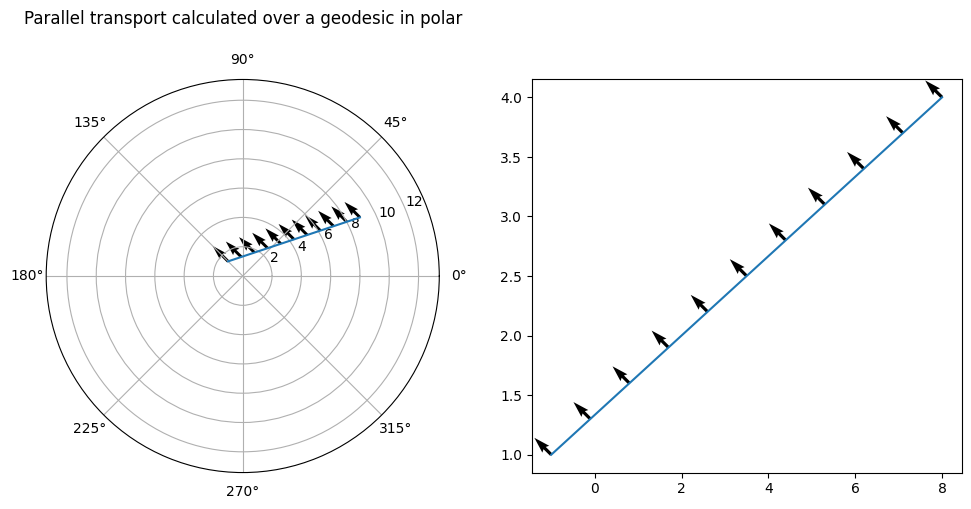

In [15]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1,projection='polar')
ax1.plot(x[3], x[2])
ax1.quiver(x[3][::100], x[2][::100], Y[0], Y[1])
ax1.set_rmax(1.5*max(x[2]))
ax1.set_title("Parallel transport calculated over a geodesic in polar", pad=40)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(u,v)
B = np.array([[u[::100]],[v[::100]],[Y[0]],[Y[1]]])
ax2.quiver(*B)


plt.tight_layout()
plt.show()